# Sentiment analysis 

### Imports

In [56]:
# Imports
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer


In [57]:
data_path = "../../data/txt_tp4/"

files = sorted([f for f in os.listdir(data_path) if f.endswith(".txt")])
texts = [open(os.path.join(data_path, f),"r",encoding="utf-8").read()
         for f in files]

def matches_query(text):
    txt = text.lower()
    cond1 = "sorcière" in txt or "sorciere" in txt
    cond2 = bool(re.search(r"\bfemm\w*|\bfémin\w*", txt))
    return cond1 and cond2

filtered = [(f,t) for f,t in zip(files,texts) if matches_query(t)]

print("Documents filtrés :", len(filtered))


Documents filtrés : 993


### Nettoyage léger 

In [58]:
def is_noise(text):
    if len(re.findall(r"\d{3,}", text)) > 30: return True
    if len(re.findall(r"\b\d{2}h\d{2}\b|\b\d{4}\b", text)) > 20: return True
    return False

clean_docs = [(f,t) for f,t in filtered if not is_noise(t)]
print("Documents utilisés pour les sentiments :", len(clean_docs))


Documents utilisés pour les sentiments : 320


### Fonction d’analyse des sentiments

In [30]:
def sentiment_scores(text):
    blob = TextBlob(text, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
    polarity, subjectivity = blob.sentiment
    return polarity, subjectivity


### Application du modèle de sentiments

In [31]:
sent_data = []

for fname, txt in clean_docs:
    pol, subj = sentiment_scores(txt)
    sent_data.append([fname, pol, subj])

df_sent = pd.DataFrame(sent_data, columns=["fichier", "polarity", "subjectivity"])
df_sent.head()


,fichier,polarity,subjectivity
0,KB_JB838_1951-01-20_01-00005.txt,0.045670,0.231531
1,KB_JB838_1951-02-04_01-00020.txt,0.134023,0.225551
2,KB_JB838_1951-05-11_01-00002.txt,0.072686,0.234284
3,KB_JB838_1951-06-09_01-00001.txt,0.078564,0.206599
4,KB_JB838_1951-06-15_01-00010.txt,0.188309,0.322500


#### Extraction date / source

In [60]:
def extract_info(filename):
    name = filename.replace(".txt", "")
    parts = name.split("_")
    journal = parts[1] if len(parts) > 1 else None
    year = None
    if len(parts) > 2:
        match = re.match(r"(\d{4})-\d{2}-\d{2}", parts[2])
        if match:
            year = int(match.group(1))
    return journal, year

df_sent["journal"], df_sent["year"] = zip(*df_sent["fichier"].apply(extract_info))
print(df_sent.head())


                            fichier  polarity  subjectivity journal  year  \
0  KB_JB838_1951-01-20_01-00005.txt  0.045670      0.231531   JB838  1951   
1  KB_JB838_1951-02-04_01-00020.txt  0.134023      0.225551   JB838  1951   
2  KB_JB838_1951-05-11_01-00002.txt  0.072686      0.234284   JB838  1951   
3  KB_JB838_1951-06-09_01-00001.txt  0.078564      0.206599   JB838  1951   
4  KB_JB838_1951-06-15_01-00010.txt  0.188309      0.322500   JB838  1951   

     label  
0  négatif  
1  positif  
2  négatif  
3  négatif  
4  positif  


### Statistiques globales

         polarity  subjectivity         year
count  320.000000    320.000000   320.000000
mean     0.120966      0.292103  1961.850000
std      0.034391      0.081108     5.871348
min      0.017950      0.173059  1951.000000
25%      0.099067      0.247802  1956.000000
50%      0.120778      0.279102  1962.000000
75%      0.139993      0.315341  1968.000000
max      0.244242      0.955172  1970.000000


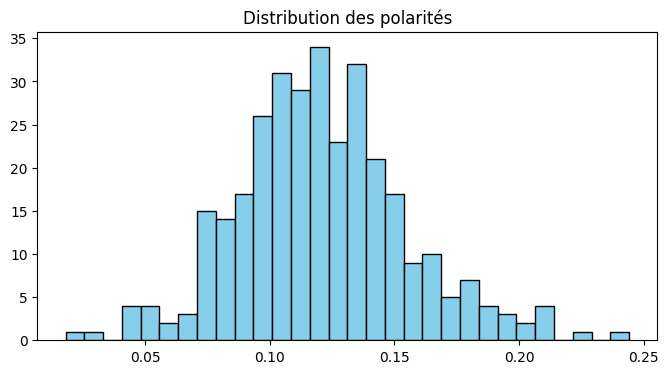

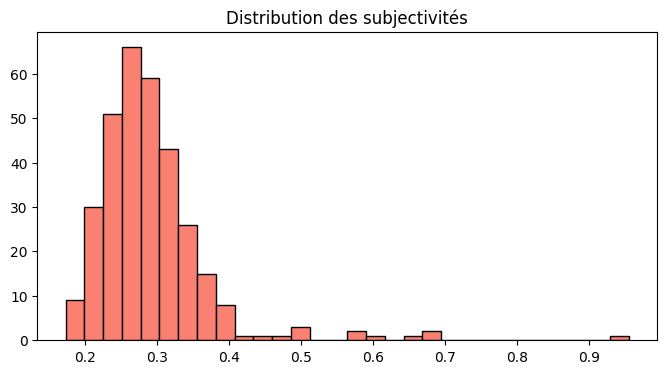

In [61]:
print(df_sent.describe())

plt.figure(figsize=(8,4))
plt.hist(df_sent["polarity"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution des polarités")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(df_sent["subjectivity"], bins=30, color="salmon", edgecolor="black")
plt.title("Distribution des subjectivités")
plt.show()


In [62]:
def label_sentiment(p):
    if p > 0.12:       # positif
        return "positif"
    elif p < 0.08:     # négatif léger inclus
        return "négatif"
    else:
        return "neutre"

df_sent["label"] = df_sent["polarity"].apply(label_sentiment)
print(df_sent["label"].value_counts())

label
positif    163
neutre     125
négatif     32
Name: count, dtype: int64


In [63]:
df_year_clean = df_sent.dropna(subset=["year"])

### Analyse temporelle

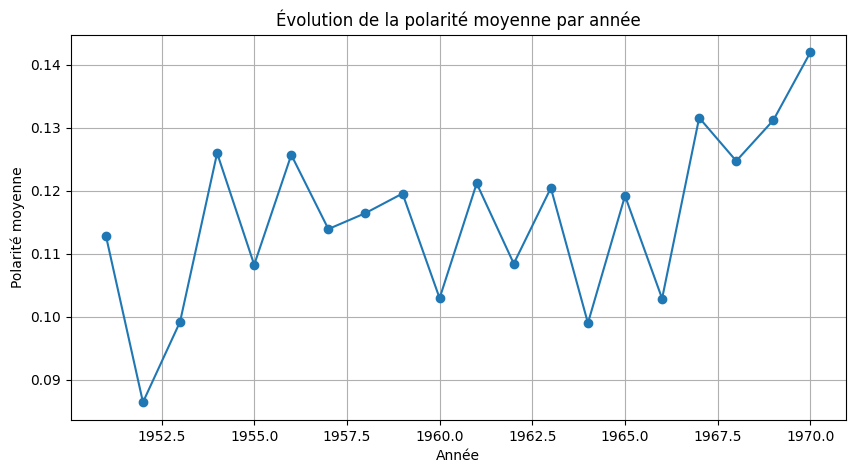

In [64]:
df_year_clean = df_sent.dropna(subset=["year"])
df_year = df_year_clean.groupby("year")["polarity"].mean().sort_index()

plt.figure(figsize=(10,5))
plt.plot(df_year.index, df_year.values, marker='o', linestyle='-')
plt.title("Évolution de la polarité moyenne par année")
plt.xlabel("Année")
plt.ylabel("Polarité moyenne")
plt.grid(True)
plt.show()


<Figure size 1200x600 with 0 Axes>

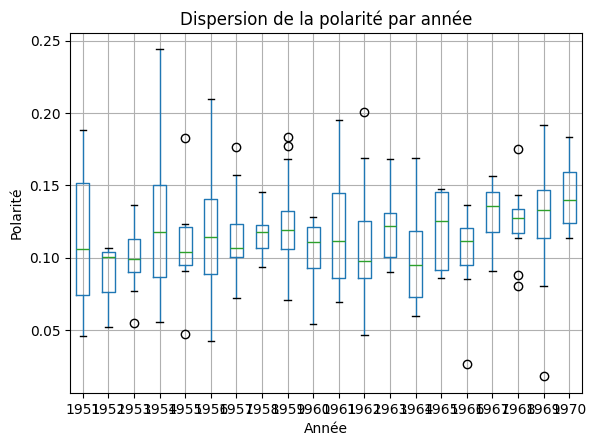

<Figure size 1200x600 with 0 Axes>

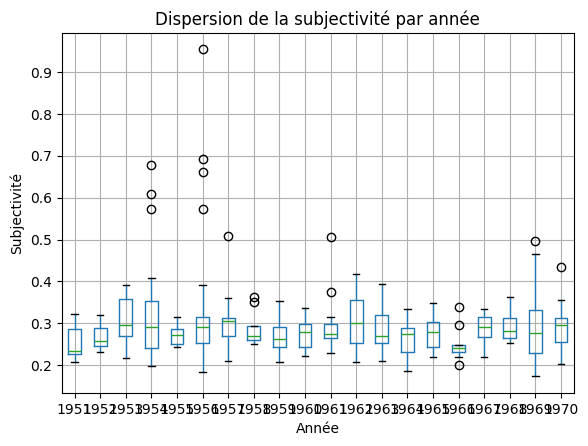

In [65]:

#Ajouter un boxplot par année pour voir la dispersion
plt.figure(figsize=(12,6))
df_year_clean.boxplot(column="polarity", by="year", grid=True)
plt.title("Dispersion de la polarité par année")
plt.suptitle("")
plt.xlabel("Année")
plt.ylabel("Polarité")
plt.show()
# même chose por la subjectivité
plt.figure(figsize=(12,6))
df_year_clean.boxplot(column="subjectivity", by="year", grid=True)
plt.title("Dispersion de la subjectivité par année")
plt.suptitle("")
plt.xlabel("Année")
plt.ylabel("Subjectivité")
plt.show()


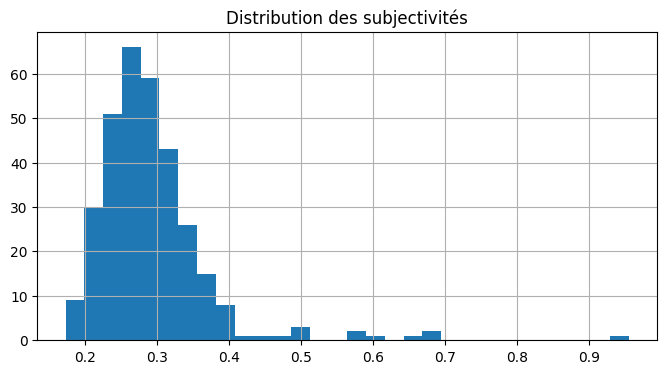

In [50]:
#Vérifier la distribution des subjectivités 
df_sent["subjectivity"].hist(bins=30, figsize=(8,4))
plt.title("Distribution des subjectivités")
plt.show()


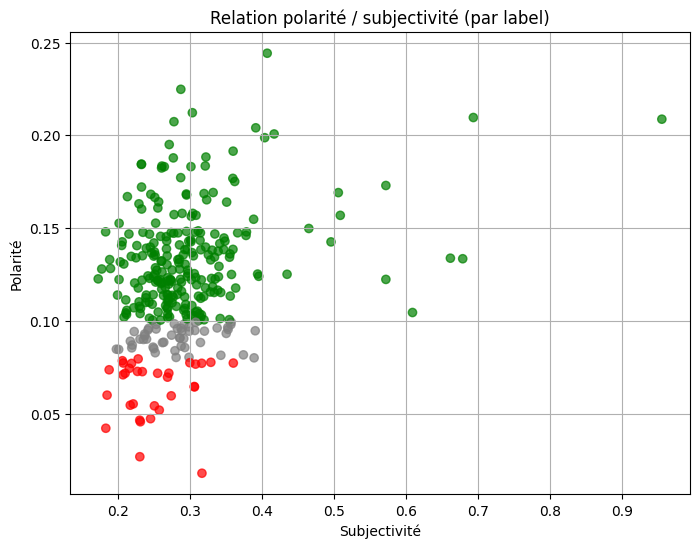

In [51]:
plt.figure(figsize=(8,6))
colors = df_sent["label"].map({"positif":"green","neutre":"gray","négatif":"red"})
plt.scatter(df_sent["subjectivity"], df_sent["polarity"], c=colors, alpha=0.7)
plt.xlabel("Subjectivité")
plt.ylabel("Polarité")
plt.title("Relation polarité / subjectivité (par label)")
plt.grid(True)
plt.show()


### Documents les plus positifs / négatifs

In [52]:
print("Top 10 articles les plus positifs :")
print(df_sent.sort_values("polarity", ascending=False).head(10))

print("\nTop 10 articles les plus négatifs :")
print(df_sent.sort_values("polarity", ascending=True).head(10))


Top 10 articles les plus positifs :
                              fichier  polarity  subjectivity journal  year  \
46   KB_JB838_1954-12-19_01-00012.txt  0.244242      0.407556   JB838  1954   
47   KB_JB838_1954-12-22_01-00010.txt  0.224797      0.287703   JB838  1954   
43   KB_JB838_1954-12-03_01-00010.txt  0.212193      0.303684   JB838  1954   
63   KB_JB838_1956-04-27_01-00014.txt  0.209600      0.693600   JB838  1956   
78   KB_JB838_1956-12-07_01-00014.txt  0.208707      0.955172   JB838  1956   
76   KB_JB838_1956-11-30_01-00012.txt  0.207359      0.278169   JB838  1956   
80   KB_JB838_1956-12-20_01-00014.txt  0.204056      0.391689   JB838  1956   
161  KB_JB838_1962-08-10_01-00012.txt  0.200734      0.417177   JB838  1962   
44   KB_JB838_1954-12-07_01-00010.txt  0.198732      0.404076   JB838  1954   
154  KB_JB838_1961-12-06_01-00013.txt  0.195039      0.271622   JB838  1961   

       label  
46   positif  
47   positif  
43   positif  
63   positif  
78   positif  
76  

### Visualisation scatter polartié/subjectivité

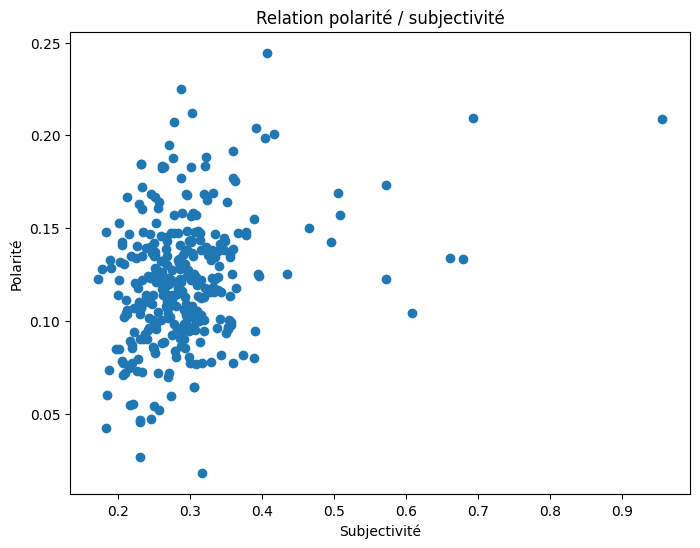

In [53]:
plt.figure(figsize=(8,6))
plt.scatter(df_sent["subjectivity"], df_sent["polarity"])
plt.xlabel("Subjectivité")
plt.ylabel("Polarité")
plt.title("Relation polarité / subjectivité")
plt.show()


In [54]:
# categorier les sentiments 
def label_sentiment(p):
    if p > 0.1: 
        return "positif"
    elif p < 0.08:  # seuil plus léger pour détecter le négatif
        return "négatif"
    else: 
        return "neutre"


df_sent["label"] = df_sent["polarity"].apply(label_sentiment)
df_sent["label"].value_counts()


label
positif    238
neutre      50
négatif     32
Name: count, dtype: int64

In [55]:
# exporter les resulata
df_sent.to_csv("sentiment_analysis_results.csv", index=False)
